# Initial WSP Data Exploration

Looking at World Stock Price dataset.

In [1]:
import pandas as pd
import numpy as np
import zipfile
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
from seaborn import set_style
set_style("whitegrid")


Some notes:

Use seasonal average model for weekends minus daylight savings weekend to create model
See how well the average predicts daylight savings weekends (null hypothesis is that there is no difference in regular weekends and daylight savings weekends)

Try seasonal average model plus linear model to account for monthly changes plus changes over the years

Use Time Series analysis

Use sklearn with rest of dataset as features and open/close as predictor

Look into using logistic regression for binary type data

In [2]:
#price2 = pd.read_csv('WSJ_HistoricalPrices(Jan 1, 1981 - Oct 10, 2024).csv')
#price1 = pd.read_csv('WSJ_HistoricalPrices(Feb 5, 1971 - Dec 31, 1980).csv')
dates = pd.read_csv('DaylightSavingsTimeChangeDates_1971-2024.csv')


zf = zipfile.ZipFile('historical_stock_prices.csv.zip') 

metadata = pd.read_csv('historical_stocks.csv')
stock_data = pd.read_csv(zf.open('historical_stock_prices.csv'))

In [6]:
dst_dates_spring = pd.to_datetime(dates.Date+" "+dates.Year.astype(str))
dst_dates_winter = pd.to_datetime(dates['Date.1']+" "+dates.Year.astype(str))
dst_mon_spring = dst_dates_spring+pd.DateOffset(1)
dst_fri_spring = dst_dates_spring+pd.DateOffset(-2)
dst_mon_winter = dst_dates_winter+pd.DateOffset(1)
dst_fri_winter = dst_dates_winter+pd.DateOffset(-2)

In [7]:
#Set datetime as index
stock_data['Date'] = pd.to_datetime(stock_data.date, utc=True).apply(lambda x: x.date())
stock_data.drop('date', inplace=True, axis=1)
stock_data['IS_DST'] = stock_data.Date.isin(pd.concat([dst_dates_spring, dst_dates_winter]))
stock_data.set_index('Date', inplace=True)
stock_data.index = stock_data.index.astype('datetime64[ns]')

In [8]:
stock_data['IS_MON'] = stock_data.index.day_of_week==0
stock_data['IS_FRI'] = stock_data.index.day_of_week==4
#wsp_data['IS_MON'] = pd.get_dummies(wsp_data[['IS_MON']]*1.0)
#wsp_data['IS_FRI'] = pd.get_dummies(wsp_data[['IS_FRI']]*1.0)


In [6]:
sectors = metadata.sector.unique()

In [9]:
fin_ticks = metadata[metadata.sector == 'FINANCE'].ticker

In [10]:
con_ticks = metadata[metadata.sector == 'CONSUMER SERVICES'].ticker

In [11]:
health_ticks = metadata[metadata.sector == 'HEALTH CARE'].ticker

In [12]:
tech_ticks = metadata[metadata.sector == 'TECHNOLOGY'].ticker

In [13]:
finance = stock_data.loc[stock_data.ticker.isin(fin_ticks.values)]

In [14]:
conservices = stock_data.loc[stock_data.ticker.isin(con_ticks.values)]

In [17]:
healthcare = stock_data.loc[stock_data.ticker.isin(health_ticks.values)]

In [18]:
tech = stock_data.loc[stock_data.ticker.isin(tech_ticks.values)]

In [19]:
#some market values to track

def daily_return(df, date): #takes dataframe and datetime64[ns]
    assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index"
    close_price = df.loc[date, 'close']
    open_price = df.loc[date, 'open']
    return close_price-open_price

def daily_percent_return(df, date): #takes dataframe and datetime64[ns]
    assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index"
    close_price = df.loc[date, 'close']
    open_price = df.loc[date, 'open']
    return (close_price-open_price)/open_price

def weekend_effect(df): #df is DataFrame for one ticker, with IS_FRI and IS_MON columns
    #assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index" 
    fri_close = df.loc[df.IS_FRI].close
    mon_open = df.loc[fri_close.index+pd.DateOffset(3)].open
    return fri_close.to_numpy() - mon_open.to_numpy(), (fri_close.to_numpy() - mon_open.to_numpy())/fri_close.to_numpy(), fri_close.index+pd.DateOffset(2) #returns (price difference, percent difference)

def hl_variability(df):
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index" 
    dates = df.loc[df.IS_FRI].low.index
    fri_hl = df.loc[df.IS_FRI].high - df.loc[df.IS_FRI].low
    mon_hl = df.loc[dates+pd.DateOffset(3)].high - df.loc[dates+pd.DateOffset(3)].low
    return mon_hl.values, fri_hl.values, dates+pd.DateOffset(2) #returns (price difference, percent difference)
    

In [20]:
#Data preprocessing for descriptive statistics (may not be applicable to time dependent processing)

dataset = pd.DataFrame()

for tk in fin_ticks:
    #Select a single stock from full dataset
    tk_set = finance.loc[finance.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
finance = dataset

In [21]:
#Same treatment for consumer services, health care, and finance
#Data preprocessing for descriptive statistics (may not be applicable to time dependent processing)

dataset = pd.DataFrame()

for tk in con_ticks:
    #Select a single stock from full dataset
    tk_set = conservices.loc[conservices.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
conservices = dataset

dataset = pd.DataFrame()

for tk in health_ticks:
    #Select a single stock from full dataset
    tk_set = healthcare.loc[healthcare.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
healthcare = dataset

dataset = pd.DataFrame()

for tk in tech_ticks:
    #Select a single stock from full dataset
    tk_set = tech.loc[tech.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
tech = dataset

In [ ]:
#tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]

In [ ]:
#wsp_data.loc[~(wsp_data.Ticker == 'NKE')].Ticker.unique()

In [12]:
fin_ticks

0         PIH
1       PIHPP
2        TURN
4        FCCY
5        SRCE
        ...  
6409      WTM
6421       WF
6436       XL
6444      YRD
6454      ZBK
Name: ticker, Length: 1022, dtype: object

In [ ]:
finance.loc[finance.ticker=='PIH']

In [ ]:
finance.loc[finance.ticker=='PIHPP']

In [ ]:
tk

In [ ]:
a, b, c = weekend_effect(finance.loc[finance.ticker == 'PIH'])

In [ ]:
c

In [ ]:
#Alter main dataset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
#wsp_data = wsp_data[((wsp_data.IS_MON==False) & (wsp_data.IS_FRI==False)) | (wsp_data.index.isin(mondays.index)) | (wsp_data.index.isin(fridays.index))]

In [ ]:
m_hl, f_hl, d_hl = hl_variability(finance.loc[finance.ticker == 'PIH'])

In [ ]:
m_hl.shape

In [95]:
#wk = []
i=0
wt = pd.DataFrame()
cs = pd.DataFrame()
hc = pd.DataFrame()
tc = pd.DataFrame()

for tk in fin_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(finance.loc[finance.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(finance.loc[finance.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    wt = pd.concat([wt, tmp])
    i+=1

for tk in con_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(conservices.loc[conservices.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(conservices.loc[conservices.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    cs = pd.concat([cs, tmp])
    i+=1

for tk in health_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(healthcare.loc[healthcare.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(healthcare.loc[healthcare.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    hc = pd.concat([hc, tmp])
    i+=1

for tk in tech_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(tech.loc[tech.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(tech.loc[tech.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    tc = pd.concat([tc, tmp])
    i+=1

In [ ]:
wt

In [102]:
wt['IS_DST'] = wt.Date.isin(pd.concat([dst_dates_spring, dst_dates_winter]))

In [103]:
cs['IS_DST'] = cs.Date.isin(pd.concat([dst_dates_spring, dst_dates_winter]))

In [104]:
hc['IS_DST'] = hc.Date.isin(pd.concat([dst_dates_spring, dst_dates_winter]))

In [105]:
tc['IS_DST'] = tc.Date.isin(pd.concat([dst_dates_spring, dst_dates_winter]))

In [31]:
wt = wt.assign(p_value = np.nan)

In [99]:
cs.Ticker

,Date,Price_Change,Percent_Change,Mon_HL_Diff,Fri_HL_Diff,Ticker,IS_DST
0,2018-08-19,-0.100000,-0.006920,0.230000,0.450000,FLWS,False
1,2018-08-12,-0.099999,-0.006873,0.280000,0.300000,FLWS,False
2,2018-08-05,0.000000,0.000000,0.250000,0.400001,FLWS,False
3,2018-07-29,0.050000,0.003484,0.760000,0.450000,FLWS,False
4,2018-07-22,-0.050000,-0.003704,0.700000,0.750000,FLWS,False
...,...,...,...,...,...,...,...
192,2014-05-18,-0.060001,-0.002108,1.100000,1.470001,ZOES,False
193,2014-05-11,-0.010000,-0.000385,0.459999,1.010000,ZOES,False
194,2014-05-04,-0.400000,-0.014467,1.620001,1.309999,ZOES,False
195,2014-04-27,0.260000,0.009342,1.299999,1.490000,ZOES,False


In [39]:
wfc_dst_mean = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == True)].Percent_Change.mean()
wfc_dst_std = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == True)].Percent_Change.std()
print("DST mean is "+str(wfc_dst_mean)+"+/-"+str(wfc_dst_std))

DST mean is 0.0018006351057250215+/-0.008134158989770811


In [40]:
wfc_reg_mean = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == False)].Percent_Change.mean()
wfc_reg_std = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == False)].Percent_Change.std()
print("Regular mean is "+str(wfc_reg_mean)+"+/-"+str(wfc_reg_std))

Regular mean is 0.0002571740587318255+/-0.010345966185592217


In [51]:
#wt.loc[wt.Ticker == 'WFC', 'p_value'] = np.full(wt.loc[wt.Ticker == 'WFC'].shape[0], 0)

In [133]:
test_data = wt.loc[wt.Ticker == 'WFC']

In [21]:
reg_set = test_data.loc[~test_data.IS_DST].Percent_Change.values
r_bin_width = 2*stats.iqr(reg_set)*(len(reg_set))**(-1/3)
reg_wkend, x_vals = np.histogram(reg_set, bins = int((np.amax(reg_set)-np.amin(reg_set))/r_bin_width), range=(np.amin(reg_set), np.amax(reg_set)), density=True)
x_vals = x_vals[:-1]+(x_vals[1:]-x_vals[:-1])/2
r_bin_err = r_bin_width/2

In [22]:
dst_set = test_data.loc[test_data.IS_DST].Percent_Change.values
d_bin_width = 2*stats.iqr(dst_set)*(len(dst_set))**(-1/3)
dst_wkend, dst_x_vals = np.histogram(dst_set, bins = int((np.amax(dst_set)-np.amin(dst_set))/d_bin_width), range=(np.amin(dst_set), np.amax(dst_set)), density=True)
dst_x_vals = dst_x_vals[:-1]+(dst_x_vals[1:]-dst_x_vals[:-1])/2
d_bin_err=d_bin_width/2

In [23]:
2*stats.iqr(reg_set)*(len(reg_set))**(-1/3)

0.0009641027320294512

In [24]:
def gaussian(x, A, x0, sigma): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [25]:
reg_parms, reg_cov = curve_fit(gaussian, x_vals, reg_wkend, p0=(np.amax(reg_wkend), 0, stats.iqr(reg_set)/2), sigma = r_bin_err+np.sqrt(reg_wkend))

In [26]:
reg_parms

array([ 3.83263921e+01, -4.42698321e-04,  5.65396795e-03])

In [27]:
dst_parms, dst_cov = curve_fit(gaussian, dst_x_vals, dst_wkend, p0=(np.amax(dst_wkend), 0, stats.iqr(dst_set)/2), sigma = d_bin_err+np.sqrt(dst_wkend))

In [28]:
dst_parms

array([5.02625278e+01, 1.42448619e-03, 6.60247580e-03])

/var/folders/jc/xvqs4hmj339bc_532ktftc6w0000gn/T/ipykernel_18112/2540748151.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_fig.show()


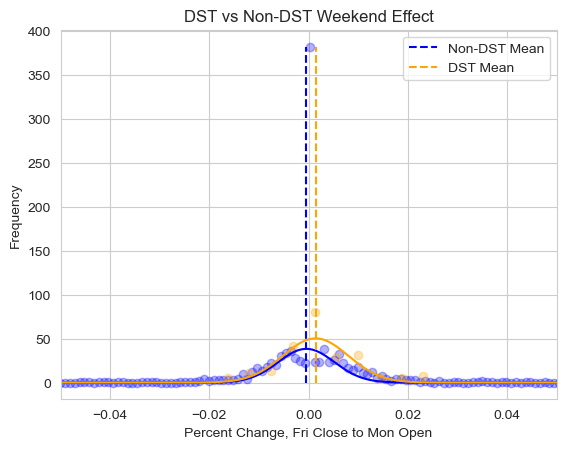

In [29]:
x_fit = np.linspace(x_vals[0], x_vals[-1], 1000)
fit_y = gaussian(x_fit, *reg_parms)
dst_fit_y = gaussian(x_fit, *dst_parms)
#fit_y = stats.norm(loc = reg_parms[1], scale = reg_parms[2])
#dst_fit_y = stats.norm(loc = dst_parms[1], scale = dst_parms[2])

test_fig, test_ax = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 12))
test_ax.plot(x_fit, fit_y, color='blue')
test_ax.scatter(x_vals, reg_wkend, color='blue', alpha=0.3)
test_ax.vlines(reg_parms[1], 0, np.amax(reg_wkend), color='blue', linestyles='dashed', label='Non-DST Mean')
test_ax.plot(x_fit, dst_fit_y, color='orange')
test_ax.scatter(dst_x_vals, dst_wkend, color='orange', alpha=0.3)
test_ax.vlines(dst_parms[1], 0, np.amax(reg_wkend), color='orange', linestyles='dashed', label='DST Mean')
test_ax.set_xlim(-0.05, 0.05)
test_ax.set_title('DST vs Non-DST Weekend Effect')
test_ax.set_ylabel('Frequency')
test_ax.set_xlabel('Percent Change, Fri Close to Mon Open')
test_ax.legend()
test_fig.show()


In [32]:
dist = stats.norm(loc=reg_parms[1], scale=np.sqrt(reg_parms[2]**2+dst_parms[2]**2)) #mean of 0 for zero difference between DST and regular, spread of each Gaussian fit added in quadrature
#z_score = np.sqrt(np.sum(reg_wkend))*(dst_parms[1] - reg_parms[1])/(reg_parms[2])
z_score = (dst_parms[1] - reg_parms[1])/np.sqrt(reg_parms[2]**2/np.sum(reg_set)+dst_parms[2]**2)
print('Z-score is '+str(z_score))
if z_score<0:
    p_val = stats.norm(loc=0, scale=1).cdf(z_score)
else:
    p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
print('p-value is '+str(p_val))

Z-score is 0.18260580591903
p-value is 0.42755366424056485


In [38]:
#dist = stats.norm(loc=reg_parms[1], scale=np.sqrt(reg_parms[2]**2+dst_parms[2]**2)) #mean of 0 for zero difference between DST and regular, spread of each Gaussian fit added in quadrature
#z_score = np.sqrt(np.sum(reg_wkend))*(dst_parms[1] - reg_parms[1])/(reg_parms[2])
z_score = (wfc_dst_mean - wfc_reg_mean)/np.sqrt(wfc_dst_std**2+wfc_reg_std**2)
print('Z-score is '+str(z_score))
if z_score<0:
    p_val = stats.norm(loc=0, scale=1).cdf(z_score)
else:
    p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
print('p-value is '+str(p_val))

Z-score is 0.11727819356135617
p-value is 0.453319802393067


In [134]:
test_data.head(10)

,Date,Price_Change,Percent_Change,Mon_HL_Diff,Fri_HL_Diff,Ticker,IS_DST
0,2018-08-19,0.049999,0.000849,0.540001,0.530003,WFC,False
1,2018-08-12,0.389999,0.006718,0.549999,1.039997,WFC,False
2,2018-08-05,0.250000,0.004250,0.840000,0.900002,WFC,False
3,2018-07-29,-0.200001,-0.003411,0.970001,0.740002,WFC,False
4,2018-07-22,0.020000,0.000355,1.790001,0.810001,WFC,False
5,2018-07-15,-0.380001,-0.006864,1.599998,2.160000,WFC,False
6,2018-07-08,-0.299999,-0.005368,0.960003,1.100002,WFC,False
7,2018-07-01,0.239998,0.004329,1.310001,1.709999,WFC,False
8,2018-06-24,0.160000,0.002966,1.040001,1.270000,WFC,False
9,2018-06-17,0.470001,0.008549,0.799999,0.989998,WFC,False


,Ticker,p_value,z_score
0,PIHPP,0.431605,0.172291


In [78]:
significance_array=pd.DataFrame()
empty=[]

for tk in fin_ticks:
    print(tk)
    
    tk_data = wt.loc[wt.Ticker == tk]
    
    #histogram for non-DST weekends
    reg_set = tk_data.loc[~tk_data.IS_DST].Percent_Change.values
    if len(reg_set)==0:
        print("reg_set for "+str(tk)+" is empty")
        empty.append(tk)
        continue
    r_bin_width = 2*stats.iqr(reg_set)*(len(reg_set))**(-1/3) #Optimal bin width via Freedman-Diaconis rule
    if r_bin_width <=0:
        print("bin error for "+str(tk))
        empty.append(tk)
        continue
    reg_wkend, x_vals = np.histogram(reg_set, bins = int((np.amax(reg_set)-np.amin(reg_set))/r_bin_width), range=(np.amin(reg_set), np.amax(reg_set)), density=True)
    x_vals = x_vals[:-1]+(x_vals[1:]-x_vals[:-1])/2 #Middle values of bins
    if ~np.all(np.isfinite(reg_wkend)) and ~np.all(np.isfinite(reg_x_vals)):
        print("histogram for "+str(tk)+" has nans/infs")
        empty.append(tk)
        continue
    if len(x_vals)<3:
        print("Not enough data to fit for "+str(tk))
        empty.append(tk)
        continue
    r_bin_err = r_bin_width/2 #X error set to half bin width
    
    #histogram for DST weekends
    dst_set = tk_data.loc[tk_data.IS_DST].Percent_Change.values
    if len(dst_set)==0:
        print("dst_set for "+str(tk)+" is empty")
        empty.append(tk)
        continue
    d_bin_width = 2*stats.iqr(dst_set)*(len(dst_set))**(-1/3) #Optimal bin width via Freedman-Diaconis rule
    if d_bin_width <=0:
        print("bin error for "+str(tk))
        empty.append(tk)
        continue
    dst_wkend, dst_x_vals = np.histogram(dst_set, bins = int((np.amax(dst_set)-np.amin(dst_set))/d_bin_width), range=(np.amin(dst_set), np.amax(dst_set)), density=True)
    dst_x_vals = dst_x_vals[:-1]+(dst_x_vals[1:]-dst_x_vals[:-1])/2 #Middle values of bins
    if ~np.all(np.isfinite(dst_wkend)) and ~np.all(np.isfinite(dst_x_vals)):
        print("histogram for "+str(tk)+" has nans/infs")
        empty.append(tk)
        continue
    if len(dst_x_vals)<3:
        print("Not enough data to fit for "+str(tk))
        empty.append(tk)
        continue
    d_bin_err=d_bin_width/2 #X error set to half bin width
    
    #non-DST Gaussian fit, error set to bin_err+sqrt(N)
    reg_parms, reg_cov = curve_fit(gaussian, x_vals, reg_wkend, p0=(np.amax(reg_wkend), 0, stats.iqr(reg_set)/2), sigma = r_bin_err+np.sqrt(reg_wkend))
    
    #DST Gaussian fit, error set to bin_err+sqrt(N)
    dst_parms, dst_cov = curve_fit(gaussian, dst_x_vals, dst_wkend, p0=(np.amax(dst_wkend), 0, stats.iqr(dst_set)/2), sigma = d_bin_err+np.sqrt(dst_wkend))
    
    z_score = (dst_parms[1] - reg_parms[1])/np.sqrt(reg_parms[2]**2+dst_parms[2]**2)
    if z_score<0:
        p_val = stats.norm(loc=0, scale=1).cdf(z_score)
    else:
        p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
    
    significance_array = pd.concat([significance_array, pd.DataFrame([{"Ticker":tk, "p_value":p_val, "z_score":z_score}])])

PIH
PIHPP
dst_set for PIHPP is empty
TURN
FCCY
SRCE
ANCX
ACNB
AGFS
AGFSW
reg_set for AGFSW is empty
ABTX
Not enough data to fit for ABTX
AMR


/var/folders/jc/xvqs4hmj339bc_532ktftc6w0000gn/T/ipykernel_67606/1249630231.py:59: OptimizeWarning: Covariance of the parameters could not be estimated
  dst_parms, dst_cov = curve_fit(gaussian, dst_x_vals, dst_wkend, p0=(np.amax(dst_wkend), 0, stats.iqr(dst_set)/2), sigma = d_bin_err+np.sqrt(dst_wkend))


Not enough data to fit for AMR
AMRWW
reg_set for AMRWW is empty
AMBC
AMBCW
reg_set for AMBCW is empty
ATAX
AMNB
ANAT
AMRB
bin error for AMRB
ABCB
AMSF
ASRV
ASRVP
ATLO
Not enough data to fit for ATLO
AFSI
ANCB
ACGL
ACGLO
Not enough data to fit for ACGLO
ACGLP
Not enough data to fit for ACGLP
AROW
ASFI
AAME
ACBI
ACFC
reg_set for ACFC is empty
ATLC
bin error for ATLC
AFH
AFHBL
reg_set for AFHBL is empty
AUBN
bin error for AUBN
BWINA
BWINB
BANF
BANFP
BCTF
Not enough data to fit for BCTF
BOCH
BMRC
BMLP
Not enough data to fit for BMLP
BKSC
BOTJ
OZRK
BFIN
BWFG
BANR
DFVL
Not enough data to fit for DFVL
DFVS
Not enough data to fit for DFVS
DLBL
Not enough data to fit for DLBL
DLBS
DTUL
Not enough data to fit for DTUL
DTUS
DTYL
DTYS
FLAT
STPP
TAPR
BHAC
bin error for BHAC
BHACR
reg_set for BHACR is empty
BHACU
reg_set for BHACU is empty
BHACW
reg_set for BHACW is empty
BCML
bin error for BCML
BCBP
BNCL
BGCP
BRPA
bin error for BRPA
BRPAR
dst_set for BRPAR is empty
BRPAU
Not enough data to fit for 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [106]:
wt

,Date,Price_Change,Percent_Change,Mon_HL_Diff,Fri_HL_Diff,Ticker,IS_DST
0,2018-08-19,-0.100000,-0.014389,0.100000,0.150000,PIH,False
1,2018-08-12,0.000000,0.000000,0.200000,0.000000,PIH,False
2,2018-08-05,0.050000,0.006944,0.347000,0.055000,PIH,False
3,2018-07-29,0.091000,0.012743,0.081000,0.041000,PIH,False
4,2018-07-22,-0.214000,-0.030200,0.200000,0.155000,PIH,False
...,...,...,...,...,...,...,...
196,2013-10-20,-0.130001,-0.004922,0.230001,0.160000,ZBK,False
197,2013-10-13,-0.170000,-0.006536,0.309999,0.179998,ZBK,False
198,2013-10-06,0.139999,0.005456,0.309999,0.340000,ZBK,False
199,2013-09-29,0.150000,0.005882,0.740000,0.380001,ZBK,False


In [107]:
fin_mean_significance_array=pd.DataFrame()
empty=[]

for tk in fin_ticks:
    #print(tk)
    
    tk_data = wt.loc[wt.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    
    #histogram for DST weekends
    dst_set = tk_data.loc[tk_data.IS_DST]
    dst_mean = dst_set.Percent_Change.mean()
    dst_std = dst_set.Percent_Change.std()
    
    z_score = (dst_mean - reg_mean)/np.sqrt(dst_std**2+reg_std**2)
    if z_score<0:
        p_val = stats.norm(loc=0, scale=1).cdf(z_score)
    else:
        p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
    
    fin_mean_significance_array = pd.concat([mean_significance_array, pd.DataFrame([{"Ticker":tk, "p_value":p_val, "z_score":z_score}])])

In [108]:
cs_mean_significance_array=pd.DataFrame()
empty=[]

for tk in con_ticks:
    #print(tk)
    
    tk_data = cs.loc[cs.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    
    #histogram for DST weekends
    dst_set = tk_data.loc[tk_data.IS_DST]
    dst_mean = dst_set.Percent_Change.mean()
    dst_std = dst_set.Percent_Change.std()
    
    z_score = (dst_mean - reg_mean)/np.sqrt(dst_std**2+reg_std**2)
    if z_score<0:
        p_val = stats.norm(loc=0, scale=1).cdf(z_score)
    else:
        p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
    
    cs_mean_significance_array = pd.concat([cs_mean_significance_array, pd.DataFrame([{"Ticker":tk, "p_value":p_val, "z_score":z_score}])])

In [109]:
hc_mean_significance_array=pd.DataFrame()
empty=[]

for tk in health_ticks:
    #print(tk)
    
    tk_data = hc.loc[hc.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    
    #histogram for DST weekends
    dst_set = tk_data.loc[tk_data.IS_DST]
    dst_mean = dst_set.Percent_Change.mean()
    dst_std = dst_set.Percent_Change.std()
    
    z_score = (dst_mean - reg_mean)/np.sqrt(dst_std**2+reg_std**2)
    if z_score<0:
        p_val = stats.norm(loc=0, scale=1).cdf(z_score)
    else:
        p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
    
    hc_mean_significance_array = pd.concat([hc_mean_significance_array, pd.DataFrame([{"Ticker":tk, "p_value":p_val, "z_score":z_score}])])

In [110]:
tc_mean_significance_array=pd.DataFrame()
empty=[]

for tk in tech_ticks:
    #print(tk)
    
    tk_data = tc.loc[tc.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    
    #histogram for DST weekends
    dst_set = tk_data.loc[tk_data.IS_DST]
    dst_mean = dst_set.Percent_Change.mean()
    dst_std = dst_set.Percent_Change.std()
    
    z_score = (dst_mean - reg_mean)/np.sqrt(dst_std**2+reg_std**2)
    if z_score<0:
        p_val = stats.norm(loc=0, scale=1).cdf(z_score)
    else:
        p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
    
    tc_mean_significance_array = pd.concat([tc_mean_significance_array, pd.DataFrame([{"Ticker":tk, "p_value":p_val, "z_score":z_score}])])

In [49]:
mean_significance_array.dropna().sort_values(by = 'p_value')

,Ticker,p_value,z_score
0,CART,0.062782,-1.531831
0,QD,0.093800,-1.317711
0,FFBW,0.171844,-0.946903
0,BOMN,0.190810,0.874917
0,RBB,0.202164,0.833916
...,...,...,...
0,PRAA,0.499707,-0.000734
0,BGCP,0.499717,0.000710
0,SIEB,0.499831,-0.000425
0,AGFS,0.499847,0.000382


In [57]:
metadata.loc[metadata.ticker == 'CART']

,ticker,exchange,name,sector,industry
522,CART,NASDAQ,"CAROLINA TRUST BANCSHARES, INC.",FINANCE,MAJOR BANKS


In [58]:
finance.loc[finance.ticker == 'CART'].shape

(437, 10)

In [59]:
sectors

array(['FINANCE', 'CONSUMER SERVICES', 'TECHNOLOGY', 'PUBLIC UTILITIES',
       'CAPITAL GOODS', 'BASIC INDUSTRIES', 'HEALTH CARE',
       'CONSUMER DURABLES', nan, 'ENERGY', 'MISCELLANEOUS', 'SECTOR',
       'TRANSPORTATION', 'CONSUMER NON-DURABLES'], dtype=object)

In [80]:
metadata.value_counts("sector")

sector
FINANCE                  1022
CONSUMER SERVICES         796
HEALTH CARE               784
TECHNOLOGY                607
CAPITAL GOODS             352
ENERGY                    286
PUBLIC UTILITIES          273
BASIC INDUSTRIES          272
CONSUMER NON-DURABLES     224
CONSUMER DURABLES         144
MISCELLANEOUS             139
TRANSPORTATION            120
SECTOR                      1
Name: count, dtype: int64

In [115]:
hc_mean_significance_array.sort_values('p_value')

,Ticker,p_value,z_score
0,RYTM,0.000483,3.300142
0,OPTN,0.133568,1.109683
0,KRYS,0.154760,1.016228
0,SPRO,0.181612,0.909238
0,CRSP,0.187352,-0.887698
...,...,...,...
0,VRNA,NaN,NaN
0,VKTXW,NaN,NaN
0,AAC,NaN,NaN
0,RCUS,NaN,NaN


In [125]:
hc_test_data = hc.loc[hc.Ticker == 'RYTM']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/jc/xvqs4hmj339bc_532ktftc6w0000gn/T/ipykernel_18112/3910670907.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_fig.show()


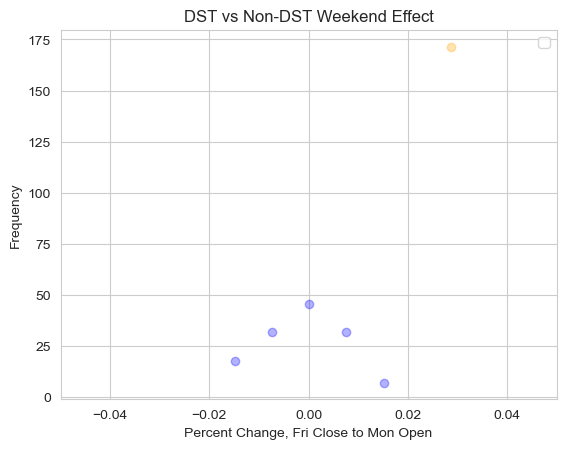

In [132]:
hc_reg_set = hc_test_data.loc[~hc_test_data.IS_DST].Percent_Change.values
r_bin_width = 2*stats.iqr(hc_reg_set)*(len(hc_reg_set))**(-1/3)
reg_wkend, x_vals = np.histogram(hc_reg_set, bins = int((np.amax(hc_reg_set)-np.amin(hc_reg_set))/r_bin_width), range=(np.amin(hc_reg_set), np.amax(hc_reg_set)), density=True)
x_vals = x_vals[:-1]+(x_vals[1:]-x_vals[:-1])/2
r_bin_err = r_bin_width/2

hc_dst_set = hc_test_data.loc[hc_test_data.IS_DST].Percent_Change.values
d_bin_width = 2*stats.iqr(hc_dst_set)*(len(hc_dst_set))**(-1/3)
dst_wkend, d_x_vals = np.histogram(hc_dst_set, bins = int((np.amax(hc_dst_set)-np.amin(hc_dst_set))/d_bin_width), range=(np.amin(hc_dst_set), np.amax(hc_dst_set)), density=True)
d_x_vals = d_x_vals[:-1]+(d_x_vals[1:]-d_x_vals[:-1])/2
d_bin_err = d_bin_width/2

#hc_reg_parms, hc_reg_cov = curve_fit(gaussian, x_vals, reg_wkend, p0=(np.amax(reg_wkend), 0, stats.iqr(hc_reg_set)/2), sigma = r_bin_err+np.sqrt(reg_wkend))
#hc_dst_parms, hc_dst_cov = curve_fit(gaussian, d_x_vals, dst_wkend, p0=(np.amax(dst_wkend), 0, stats.iqr(hc_dst_set)/2), sigma = d_bin_err+np.sqrt(dst_wkend))

#x_fit = np.linspace(x_vals[0], x_vals[-1], 1000)
#fit_y = gaussian(x_fit, *reg_parms)
#d_x_fit = np.linspace(d_x_vals[0], d_x_vals[-1], 1000)
#dst_fit_y = gaussian(d_x_fit, *dst_parms)
#fit_y = stats.norm(loc = reg_parms[1], scale = reg_parms[2])
#dst_fit_y = stats.norm(loc = dst_parms[1], scale = dst_parms[2])

test_fig, test_ax = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 12))
#test_ax.plot(x_fit, fit_y, color='blue')
test_ax.scatter(x_vals, reg_wkend, color='blue', alpha=0.3)
#test_ax.vlines(reg_parms[1], 0, np.amax(reg_wkend), color='blue', linestyles='dashed', label='Non-DST Mean')
#test_ax.plot(d_x_fit, dst_fit_y, color='orange')
test_ax.scatter(d_x_vals, dst_wkend, color='orange', alpha=0.3)
#test_ax.vlines(dst_parms[1], 0, np.amax(reg_wkend), color='orange', linestyles='dashed', label='DST Mean')
test_ax.set_xlim(-0.05, 0.05)
test_ax.set_title('DST vs Non-DST Weekend Effect')
test_ax.set_ylabel('Frequency')
test_ax.set_xlabel('Percent Change, Fri Close to Mon Open')
test_ax.legend()
test_fig.show()


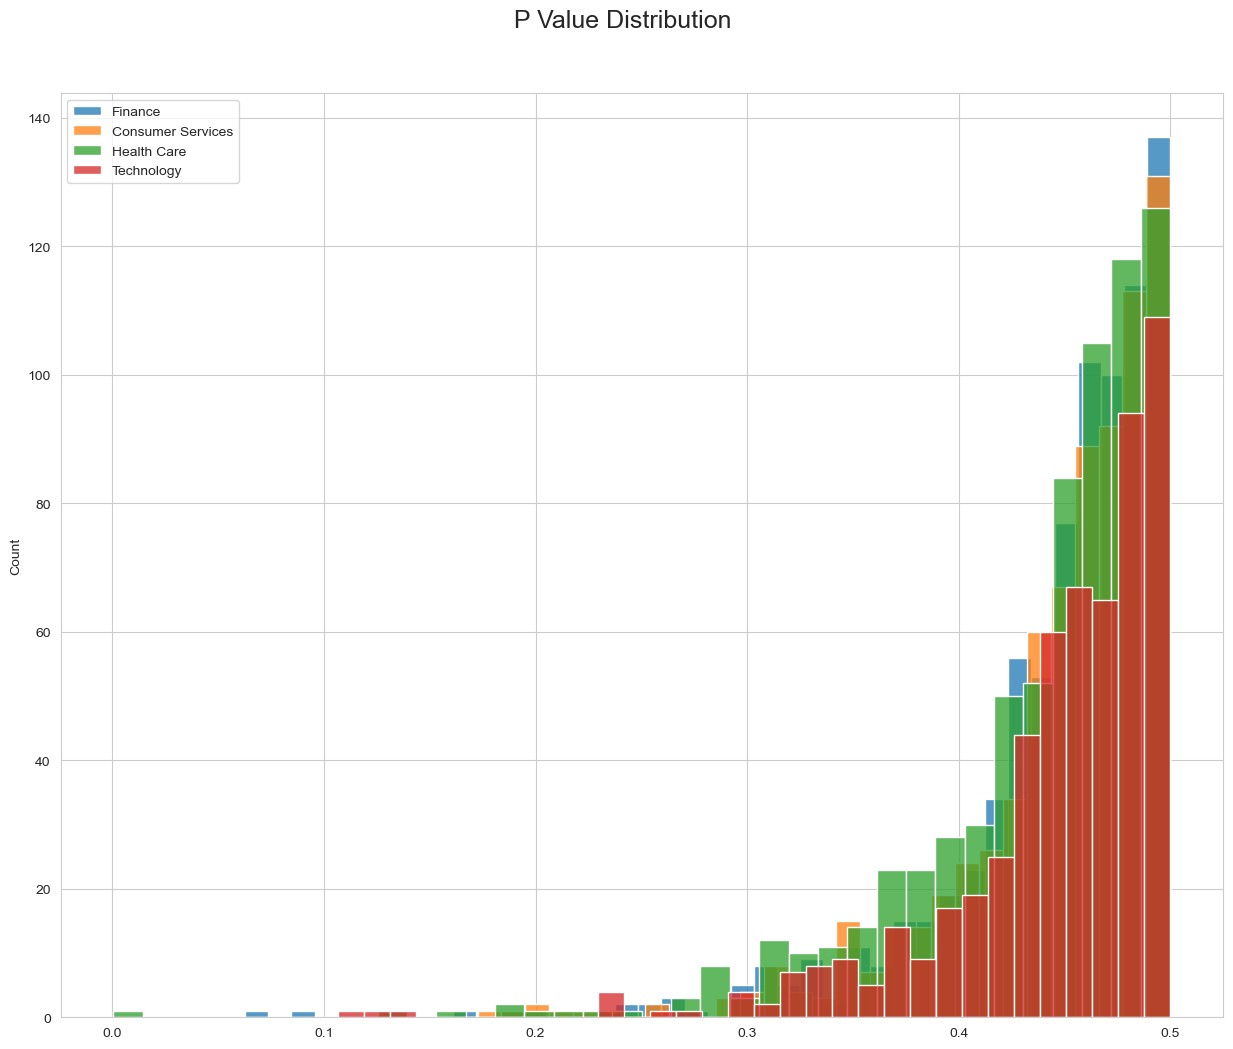

In [114]:
# define subplot grid
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("P Value Distribution", fontsize=18, y=0.95)

# loop through tickers and axes
#for tk, axes in zip(ticker_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
sns.histplot(ax=axes, data = fin_mean_significance_array.dropna(), x="p_value", label='Finance')#, kde=True)
sns.histplot(ax=axes, data = cs_mean_significance_array.dropna(), x="p_value", label='Consumer Services')#, kde=True)
sns.histplot(ax=axes, data = hc_mean_significance_array.dropna(), x="p_value", label='Health Care')#, kde=True)
sns.histplot(ax=axes, data = tc_mean_significance_array.dropna(), x="p_value", label='Technology')#, kde=True)

axes.legend()

    # chart formatting
#axes.set_title(tk.upper())
    #axes.get_legend().remove()
axes.set_xlabel("")

plt.show()